In [169]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["OMP_NUM_THREADS"] = "6" 
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length
from TSB_UAD.utils.visualisation import plotFig
from TSB_UAD.vus.metrics import  get_metrics
from sklearn.preprocessing import MinMaxScaler

from TSB_UAD.models.iforest import IForest
from TSB_UAD.models.lof import LOF
from TSB_UAD.models.matrix_profile import MatrixProfile

from TSB_UAD.models.damp import DAMP
from TSB_UAD.models.sand import SAND
from TSB_UAD.models.matrix_profile import MatrixProfile

# Interval Matrix Profile Library
import sys
sys.path.insert(0,'../build/src/')
import libimp

In [170]:
# Prepare data for unsupervised method

filepath = '../Data/benchmark/Daphnet/S09R01E0.test.csv@1.out'
df = pd.read_csv(filepath, header=None).dropna().to_numpy()

name = filepath.split('/')[-1]
max_length = 10000

data = df[:max_length,0].astype(float)
label = df[:max_length,1].astype(int)
    
slidingWindow = find_length(data)


print("Estimated Subsequence length: ",slidingWindow)
print("Time series length: ",len(data))
print("Number of abnormal points: ",list(label).count(1))

Estimated Subsequence length:  72
Time series length:  9600
Number of abnormal points:  323


In [171]:
def find_period(signal):
    acf = np.correlate(signal, signal, 'full')[-len(signal):]
    inflection = np.diff(np.sign(np.diff(acf)))
    peaks = (inflection < 0).nonzero()[0] + 1
    return peaks[acf[peaks].argmax()]
period = find_period(data)
n_period = int(len(data) / period)

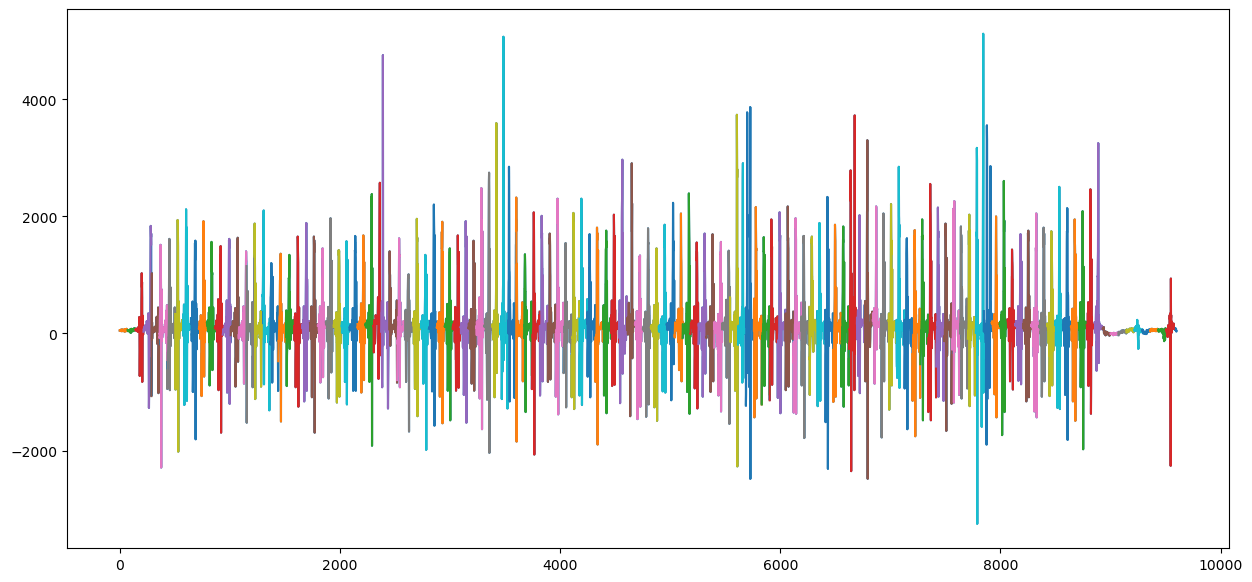

In [172]:
plt.figure(figsize=(15,7))
plt.plot(data)
period_starts = [i*period for i in range(n_period)]
for p in range(n_period):
    x = np.arange(p*period, (p+1)*period)
    plt.plot(x, data[p*period:(p+1)*period])
    
plt.show()

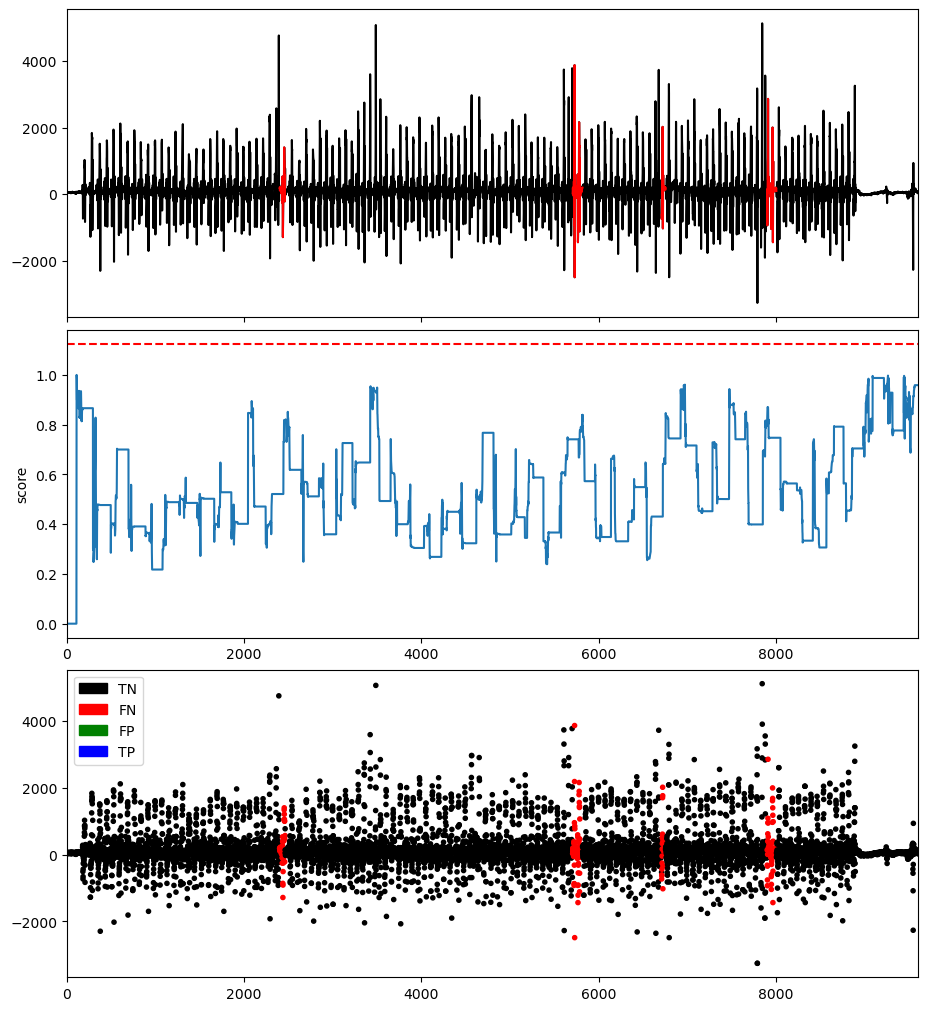

In [173]:
modelName='DAMP'
clf = DAMP(m = slidingWindow,sp_index=slidingWindow+1)
x = data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)
#get_metrics(score, label, slidingWindow=2*slidingWindow, metric="vus", version='opt_mem')

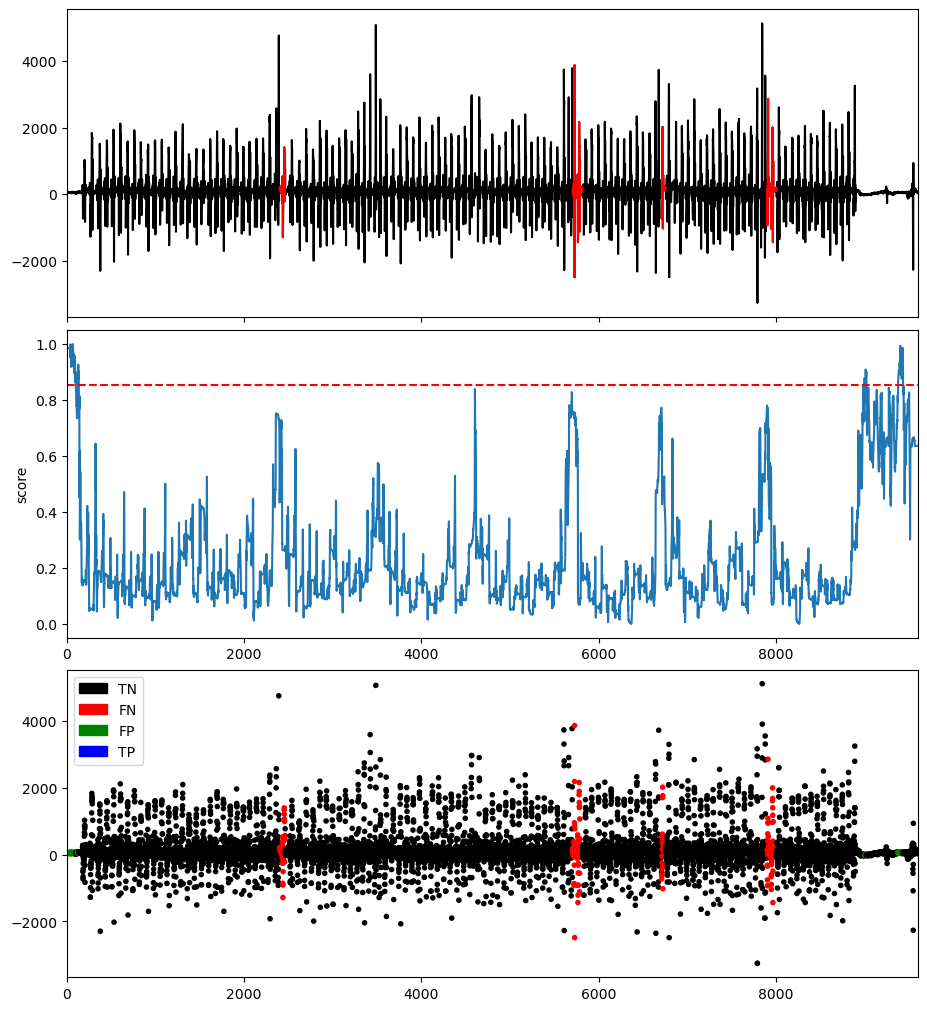

In [174]:
modelName='MP'
clf = MatrixProfile(slidingWindow)
x = data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)
#get_metrics(score, label)

In [175]:
period,slidingWindow

(72, 72)

{'AUC_ROC': 0.5918692355107058,
 'AUC_PR': 0.041739484170634895,
 'Precision': 0.0,
 'Recall': 0.0,
 'F': 0.0,
 'Precision_at_k': 0.0,
 'Rprecision': 0.0,
 'Rrecall': 0.0,
 'RF': 0,
 'R_AUC_ROC': 0.6021050229549009,
 'R_AUC_PR': 0.04299498721931396,
 'VUS_ROC': 0.596416857456967,
 'VUS_PR': 0.04226535027824435,
 'Affiliation_Precision': 0.4650180166897575,
 'Affiliation_Recall': 0.9947259503264001}

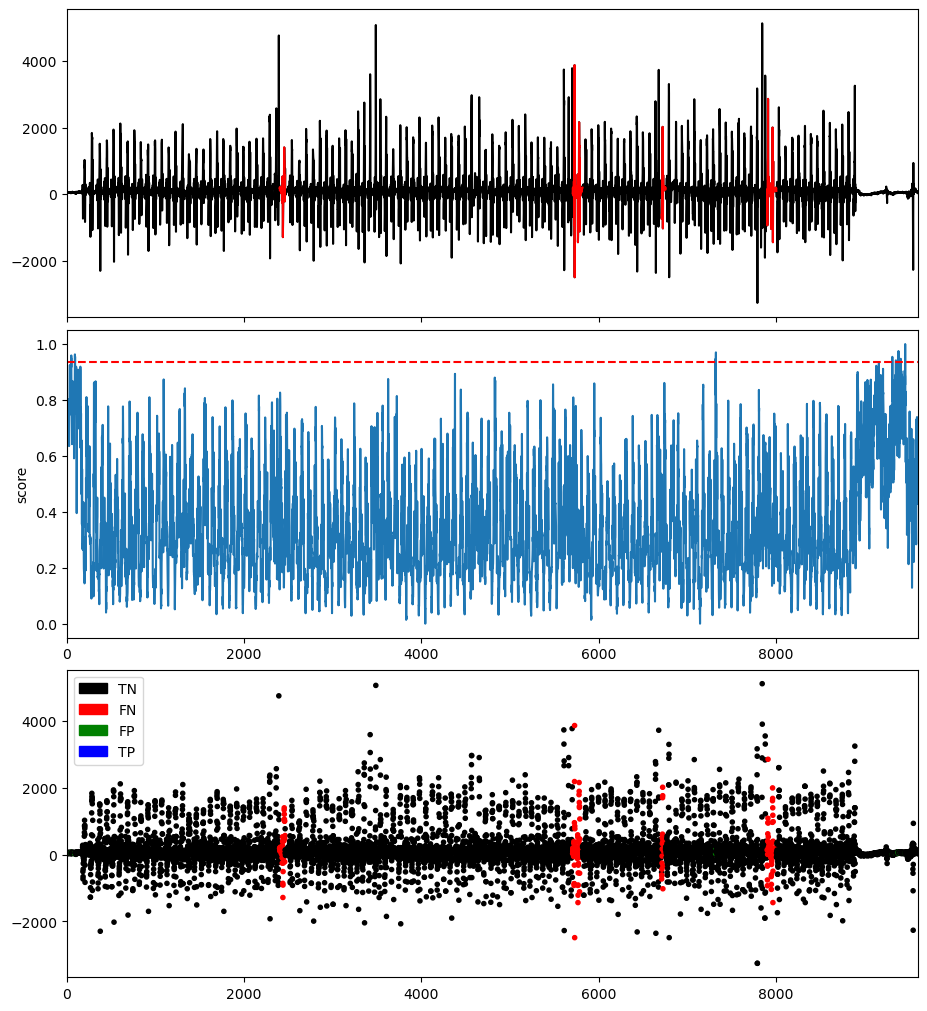

In [176]:
modelName='IMP'
window = period//4
score, _ = libimp.znormalized_bf_double(data, window, period_starts, period//2, window)

score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((window-1)/2) + list(score) + [score[-1]]*((window-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)
get_metrics(score, label,thre=100)